In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
import os
import tqdm

import seaborn as sns
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.utils import make_grid
from attrdict import AttrDict
import torch
import yaml
from sklearn.model_selection import StratifiedKFold
import copy
import pickle
# from tqdm import tqdm_notebook

# additional lightning 

import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import LightningDataModule, LightningModule

import torch
from torch import nn
import torch.nn.functional as F
from timm import create_model

import gc

In [6]:
##################
# VM USE THIS
##################
import sys
sys.path.append("../")
from pawnet.utility import *


##################
# KAGGLE USE THIS
##################
# you need to import the utility script by uploading to kaggle as pawnet_utility/pawnet_utility.py
# from pawnet_utility import *

In [7]:
# extra augmentations for experiments
import pawnet.augmentations as aug_utils

In [8]:
# cka
import pawnet.visualization as viz_utils

# Load feature maps

In [16]:
with open("swin.pkl","rb") as fin:
    [swin] = pickle.load(fin)
    
# compute gram
swin_gram = torch.matmul(swin.permute(0,2,1),swin)

swin_gram = swin_gram.view(-1,swin_gram.shape[1] * swin_gram.shape[2])

In [17]:
with open("densenet.pkl","rb") as fin:
    [dense] = pickle.load(fin)
    
# compute gram
dense = dense.view(dense.shape[0],dense.shape[1],dense.shape[2]*dense.shape[3])
dense_gram = torch.matmul(dense,dense.permute(0,2,1))

dense_gram = dense_gram.view(-1,dense_gram.shape[1] * dense_gram.shape[2])

In [18]:
with open("efficientnet.pkl","rb") as fin:
    [efficientnet] = pickle.load(fin)
    
# compute gram
efficientnet = efficientnet.view(efficientnet.shape[0],efficientnet.shape[1],efficientnet.shape[2]*efficientnet.shape[3])
efficientnet_gram = torch.matmul(efficientnet,efficientnet.permute(0,2,1))

efficientnet_gram = efficientnet_gram.view(-1,efficientnet_gram.shape[1] * efficientnet_gram.shape[2])

In [19]:
with open("resnet.pkl","rb") as fin:
    [resnet] = pickle.load(fin)
    
# compute gram
resnet = resnet.view(resnet.shape[0],resnet.shape[1],resnet.shape[2]*resnet.shape[3])
resnet_gram = torch.matmul(resnet,resnet.permute(0,2,1))

resnet_gram = resnet_gram.view(-1,resnet_gram.shape[1] * resnet_gram.shape[2])

In [20]:
with open("vit_small.pkl","rb") as fin:
    [vit] = pickle.load(fin)
    
# compute gram
vit_gram = torch.matmul(vit.permute(0,2,1),vit)

vit_gram = vit_gram.view(-1,vit_gram.shape[1] * vit_gram.shape[2])

# CKA

In [23]:
list_grams = [resnet_gram,efficientnet_gram,dense_gram,swin_gram,vit_gram]
cka_matrix = np.zeros((5,5))

In [30]:
# compute pairwise CKA
cka = viz_utils.CudaCKA(device ="cpu")
for i,gram in enumerate(list_grams):
    for j,gram_pair in enumerate(list_grams):
        # compute pairwise CKA
        cka_matrix[i,j]= cka.linear_CKA(X=gram,Y=gram_pair).detach().numpy()

In [31]:
cka_matrix

array([[1.        , 0.79575735, 0.76134151, 0.68198615, 0.09830096],
       [0.79575735, 1.        , 0.76219547, 0.6503855 , 0.10582014],
       [0.76134151, 0.76219547, 1.        , 0.67735887, 0.11902721],
       [0.68198615, 0.6503855 , 0.67735887, 1.00000012, 0.10050593],
       [0.09830096, 0.10582014, 0.11902721, 0.10050593, 1.        ]])

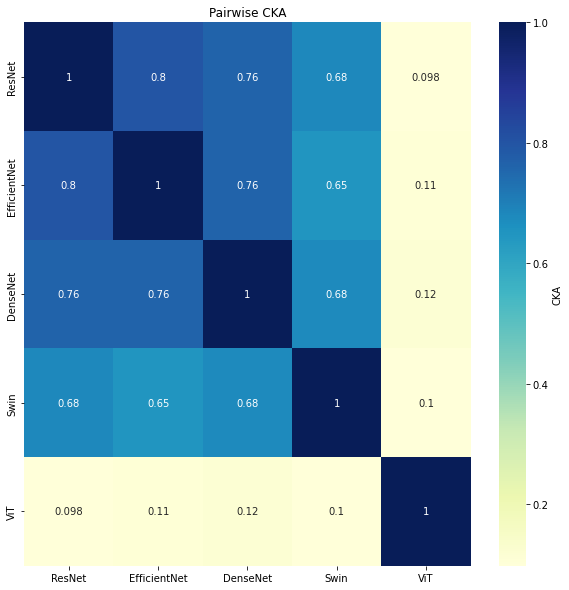

In [42]:
fig,axes = plt.subplots(figsize=(10,10))
sns.heatmap(cka_matrix,annot=True,ax=axes,xticklabels=["ResNet","EfficientNet","DenseNet","Swin","ViT"],yticklabels=["ResNet","EfficientNet","DenseNet","Swin","ViT"],cbar_kws={"label":"CKA"},cmap="YlGnBu")
axes.set_title("Pairwise CKA")
plt.savefig("cka_plot.png")